In [1]:
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

In [2]:
"""Cumulative sum algorithm (CUSUM) to detect abrupt changes in data."""

from __future__ import division, print_function
import numpy as np
import pandas as pd

__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"

In [3]:
def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).

    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.

    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.

    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.

    See this IPython Notebook [2]_.

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)

    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp

In [4]:
def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

In [5]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=14400):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [6]:
all_data = get_ohlcv_poloniex(pair='USDT_BTC', start=1483600958, end=9999999999, period=86400)
all_data['ds'] = pd.to_datetime(all_data['date'], unit='s')

In [7]:
df = all_data[['ds','weightedAverage','volume','high','low']]
df['range'] = df['high']-df['low']
df = df.drop('high', axis=1)
df = df.drop('low', axis=1)
df = df.rename(index=str, columns={'weightedAverage':'price'})

In [8]:
df.describe()

,price,volume,range
count,638.000000,6.380000e+02,638.000000
mean,5842.545972,3.292258e+07,478.145479
std,3890.256855,4.180172e+07,590.853897
min,787.033432,1.733063e+05,8.839478
25%,2366.763848,6.821477e+06,139.014734
50%,6302.054297,1.846042e+07,274.010000
75%,8097.084165,4.139485e+07,549.952839
max,19236.130652,3.960385e+08,4157.404475


By going through thresholds in the values [1,50,200,500,1000] comapred to both a low and a high drift value the graphs for each of the threshold values gives an awesome representation of the start and end for each movement ranging from slight fluctuations to major market moves. The high and low drift pairings show either a more tolerant move in that range or a swift movement.



        ---------------------------------------------   1  -  0   ---------------------------------------------


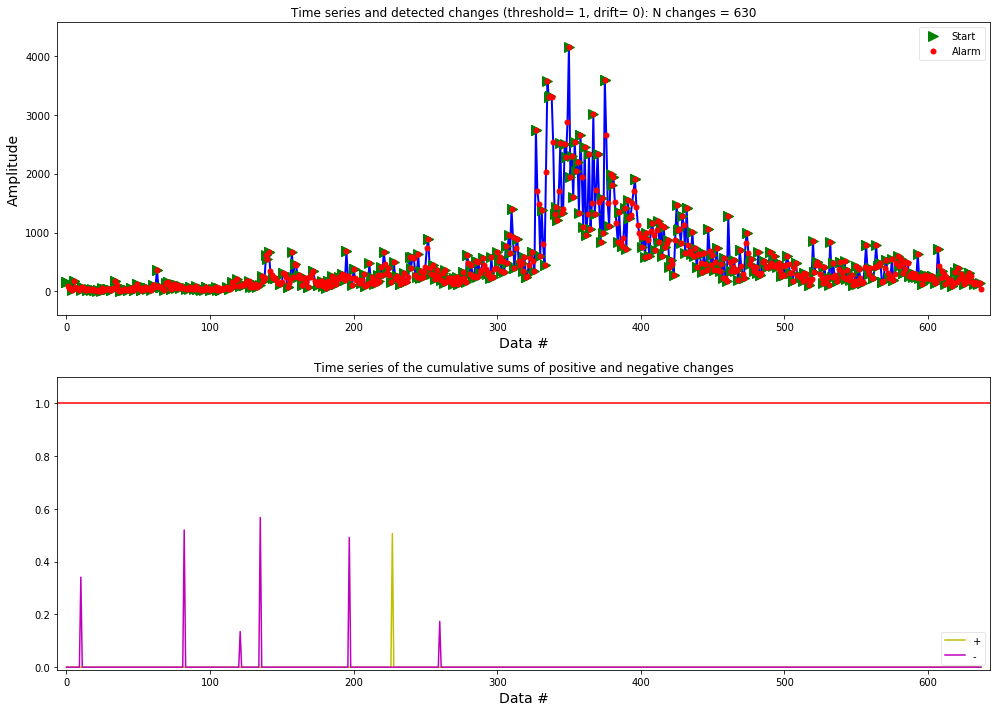



        ---------------------------------------------   1  -  100   ---------------------------------------------


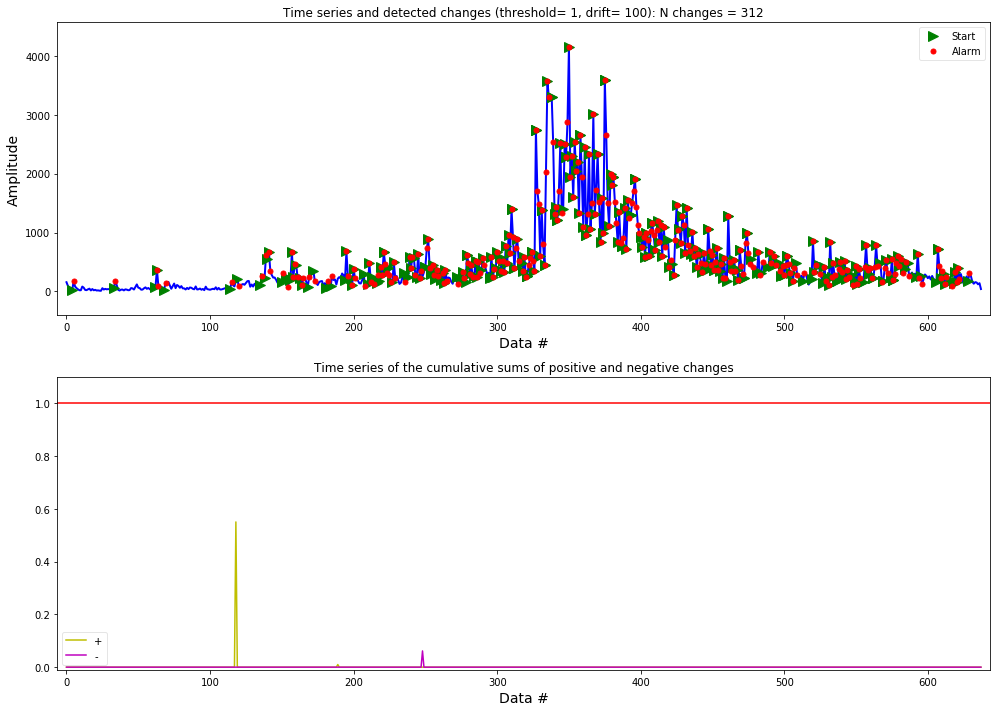



        ---------------------------------------------   50  -  20   ---------------------------------------------


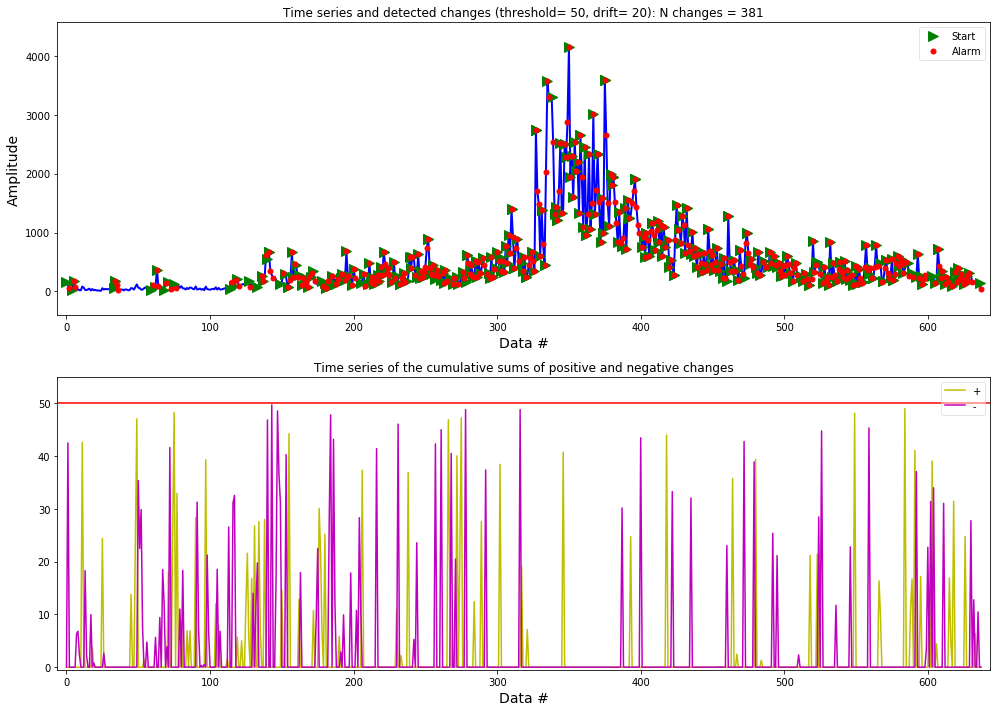



        ---------------------------------------------   50  -  100   ---------------------------------------------


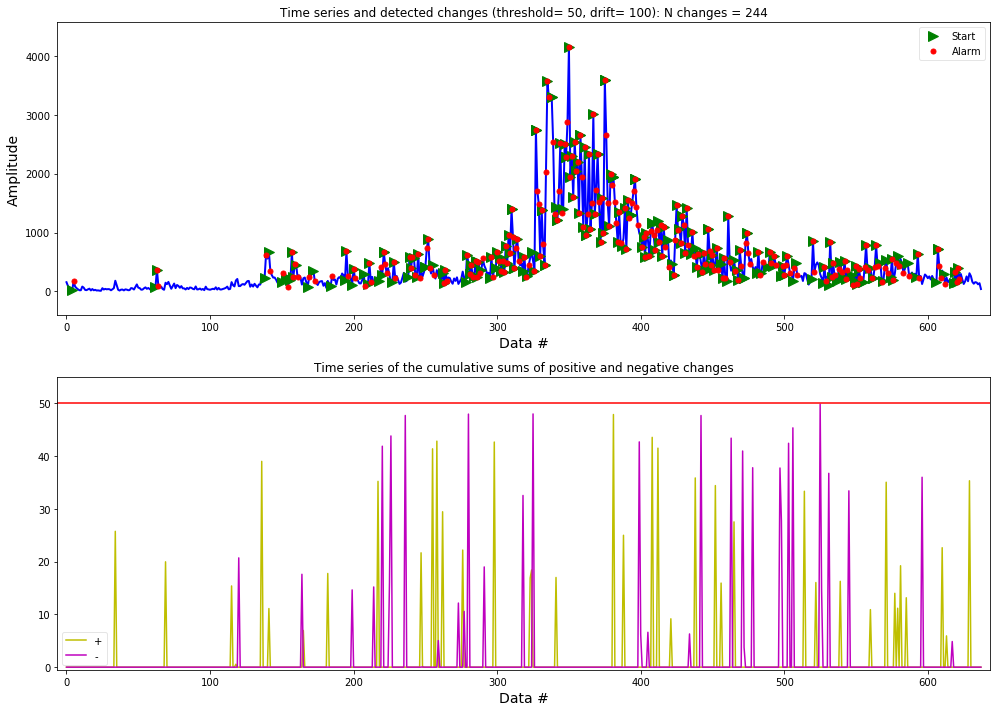



        ---------------------------------------------   200  -  40   ---------------------------------------------


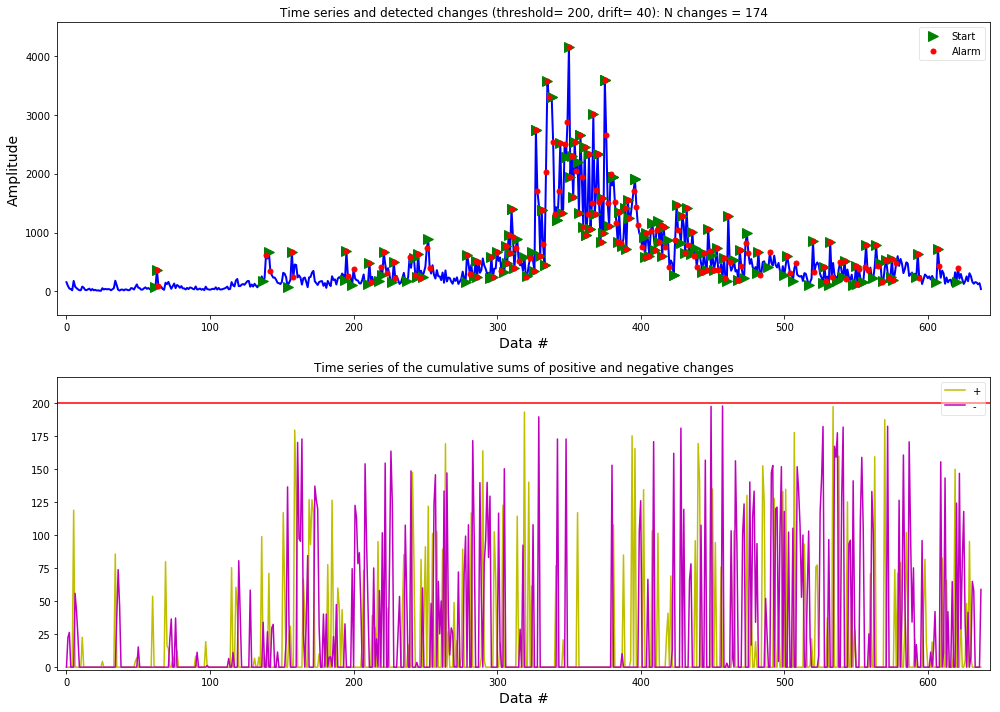



        ---------------------------------------------   200  -  100   ---------------------------------------------


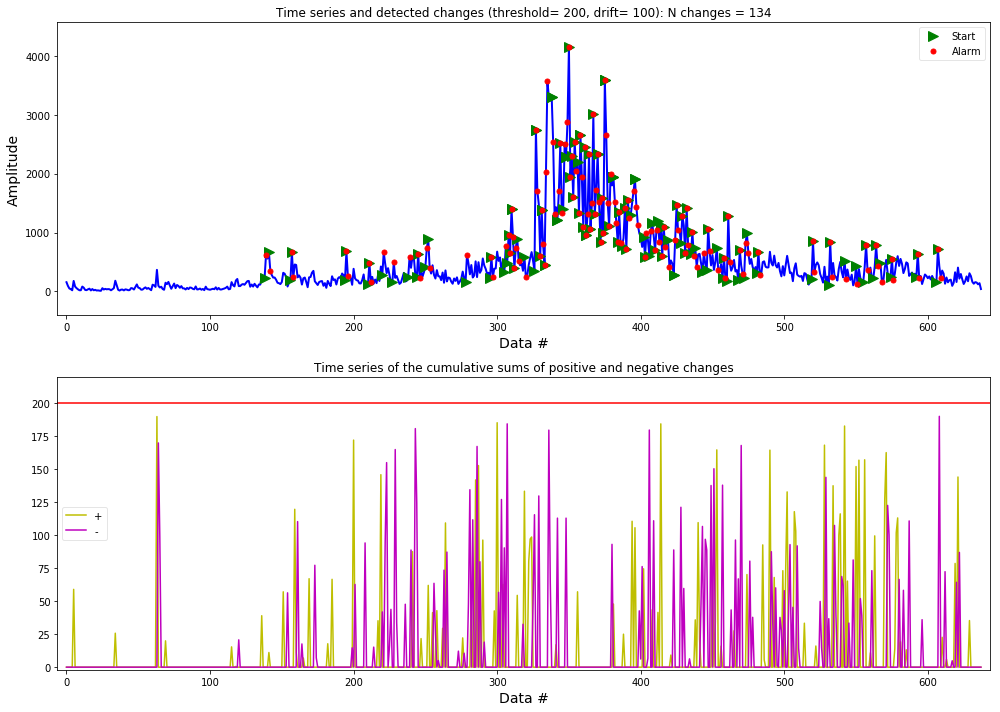



        ---------------------------------------------   500  -  60   ---------------------------------------------


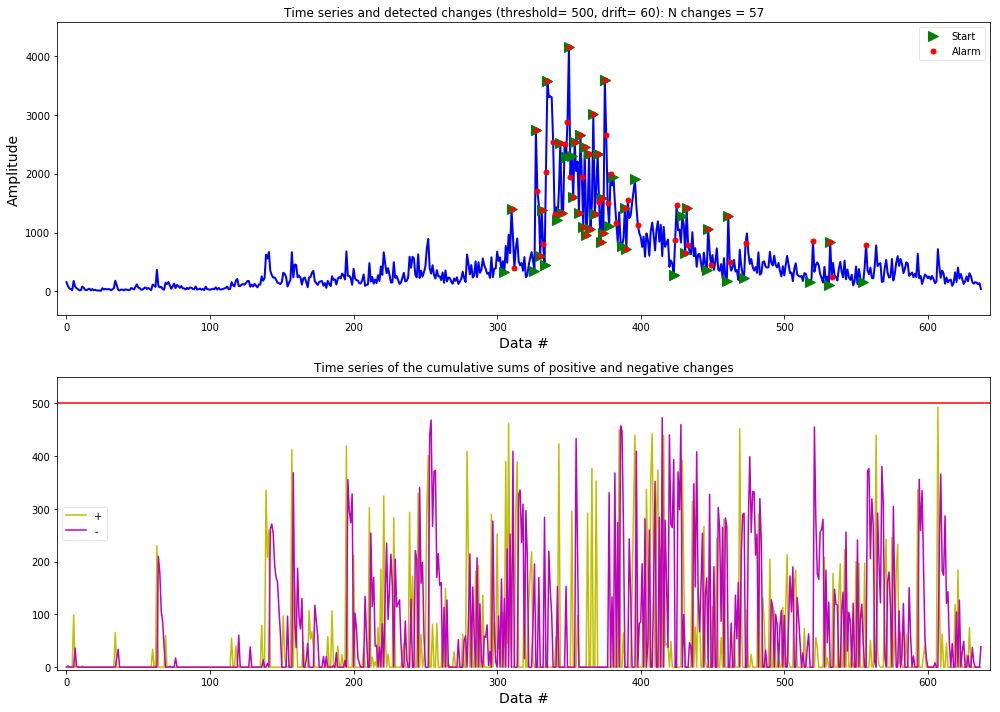



        ---------------------------------------------   500  -  100   ---------------------------------------------


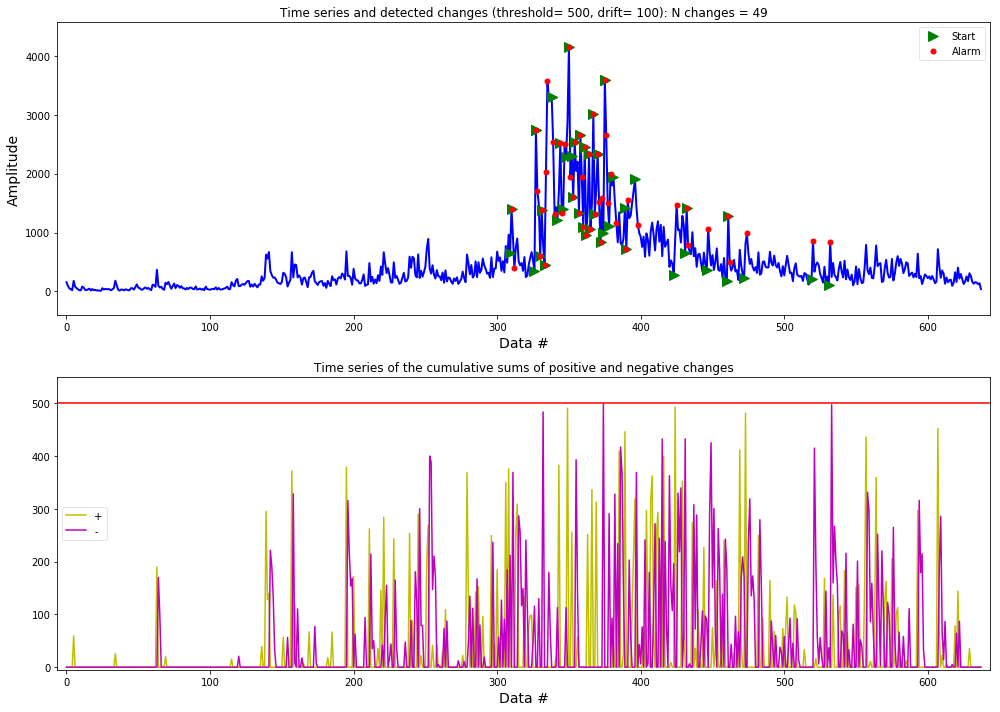



        ---------------------------------------------   1000  -  100   ---------------------------------------------


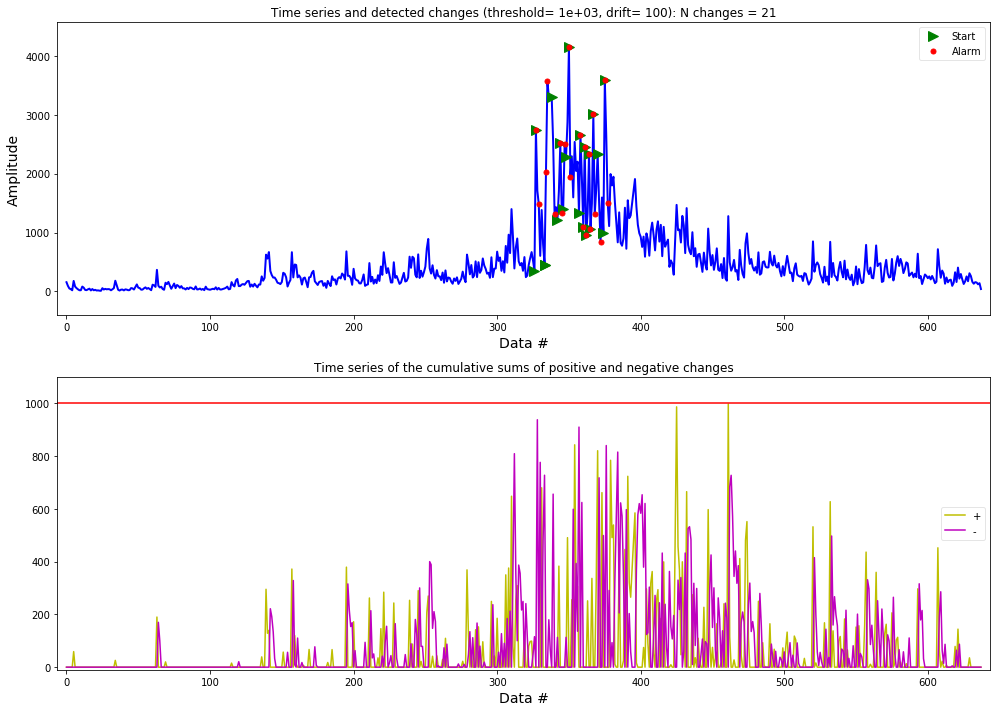



        ---------------------------------------------   1000  -  500   ---------------------------------------------


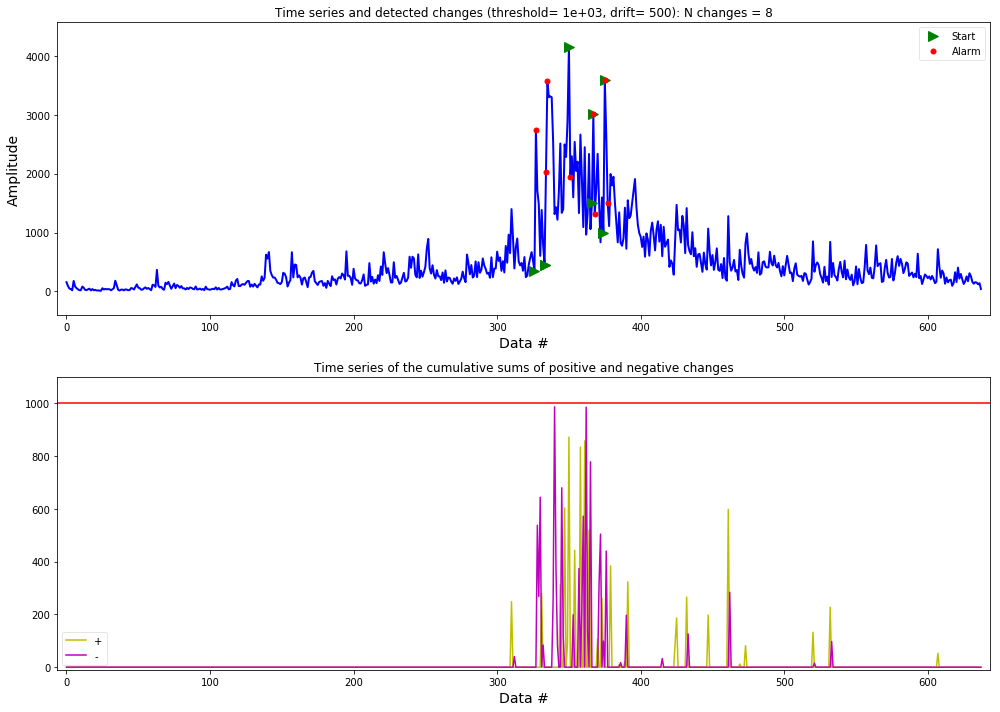

In [9]:
values = [(1,0),(1,100),(50,20),(50,100),(200,40),(200,100),(500,60),(500,100),(1000,100),(1000,500)]

for threshold, drift in values:
    print("\n"*2," "*6,"-"*45," ",threshold," - ",drift," ","-"*45)
    ax, ta, tai, taf = detect_cusum(df['range'], threshold=threshold, drift=drift)